In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os
import joblib


In [21]:
data = joblib.load('data_with_features.joblib')
data

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126..."
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10..."
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096..."
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0...."
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0...."
...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737..."


In [3]:
print(data.columns)

Index(['ECNumber', 'Organism', 'Smiles', 'Substrate', 'Sequence', 'Raw Kd',
       'Unit', 'Log Kd', 'metabolite_features', 'protein_features'],
      dtype='object')


In [4]:
# adding 1e-9 to prevent error when doing logarithm
# ??????
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [5]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [6]:
# Separate the dataset by unique proteins and drugs
unique_proteins = data['Sequence'].unique()
unique_mols = data['Smiles'].unique()
# Set the seed for reproducibility
torch.manual_seed(42)
# Function to perform a cold split
def cold_split(unique_items, test_size=0.2, val_size=0.1):
    train_items, test_items = train_test_split(unique_items, test_size=test_size, random_state=42)
    train_items, val_items = train_test_split(train_items, test_size=val_size / (1 - test_size), random_state=42)
    return train_items, val_items, test_items
# Cold split by proteins
train_proteins, val_proteins, test_proteins = cold_split(unique_proteins)
train_cold_protein = data[data['Sequence'].isin(train_proteins)]
val_cold_protein = data[data['Sequence'].isin(val_proteins)]
test_cold_protein = data[data['Sequence'].isin(test_proteins)]
# Cold split by molecules
train_mols, val_mols, test_mols = cold_split(unique_mols)
train_cold_mols = data[data['Smiles'].isin(train_mols)]
val_cold_mols = data[data['Smiles'].isin(val_mols)]
test_cold_mols = data[data['Smiles'].isin(test_mols)]

In [7]:
# cold protein
'''
train_dataset = MPI_Dataset(train_cold_protein)
val_dataset = MPI_Dataset(val_cold_protein)
test_dataset = MPI_Dataset(test_cold_protein)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

# cold mols

'''
train_dataset = MPI_Dataset(train_cold_mols)
val_dataset = MPI_Dataset(val_cold_mols)
test_dataset = MPI_Dataset(test_cold_mols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

'''

'\ntrain_dataset = MPI_Dataset(train_cold_mols)\nval_dataset = MPI_Dataset(val_cold_mols)\ntest_dataset = MPI_Dataset(test_cold_mols)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n\n'

In [8]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define CNN Model for Regression
class CNNRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, out_dim=1):
        super(CNNRegressor, self).__init__()

        self.mol_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        self.protein_conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        with torch.no_grad():
            dummy_mol = torch.zeros(1, 1, mol_input_dim)
            dummy_protein = torch.zeros(1, 1, protein_input_dim)
    
            mol_flatten_len = self.mol_conv(dummy_mol).view(1, -1).size(1)
            protein_flatten_len = self.protein_conv(dummy_protein).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(mol_flatten_len + protein_flatten_len, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, mol_input, protein_input):
        # Reshape to (B, 1, L) for Conv1d
        mol_input = mol_input.unsqueeze(1)
        protein_input = protein_input.unsqueeze(1)

        mol_out = self.mol_conv(mol_input)
        protein_out = self.protein_conv(protein_input)

        # Flatten
        mol_out = mol_out.view(mol_out.size(0), -1)
        protein_out = protein_out.view(protein_out.size(0), -1)

        combined = torch.cat([mol_out, protein_out], dim=1)
        output = self.fc(combined).squeeze()
        return output


In [10]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()




Training Epoch 1: 100%|██████████| 373/373 [00:02<00:00, 145.45it/s]


Epoch 0 - Train Loss: 2.2305, Train MSE: 2.2291, Train MAE: 1.1663


C:\Users\youbowei0126\AppData\Local\Temp\ipykernel_16256\3486802603.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Validation Loss: 2.2195, Validation MSE: 2.2178, Validation MAE: 1.1531


Training Epoch 9:  23%|██▎       | 84/373 [00:00<00:01, 258.46it/s]


KeyboardInterrupt: 

In [ ]:
# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)

# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = torch.sqrt((torch.tensor(test_predictions) - torch.tensor(test_labels)) ** 2).mean().item()
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

In [17]:
# append the performance to the csv file
df = {
    'Model':['CNN','CNN','CNN'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_history['Train MSE'].mean(),train_history['Val MSE'].mean(),test_mse],
    'RMSE':[train_history['Train RMSE'].mean(),train_history['Val RMSE'].mean(),test_rmse],
    'MAE':[train_history['Train MAE'].mean(),train_history['Val MAE'].mean(),test_mae],
    'R2':[train_history['Train R2'].mean(),train_history['Val R2'].mean(),test_r2],
    'Pearson':[train_history['Train Pearson'].mean(),train_history['Val Pearson'].mean(),test_pearson_corr],
    'Median_AE':[train_history['Train Median_AE'].mean(),train_history['Val Median_AE'].mean(),test_median_ae],
    'Explained_VAR':[train_history['Train Explained_VAR'].mean(),train_history['Val Explained_VAR'].mean(),test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [18]:
# Save the model and training history
save_dir = './trained_model'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'CNN model.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'CNN optimizer.pt'))

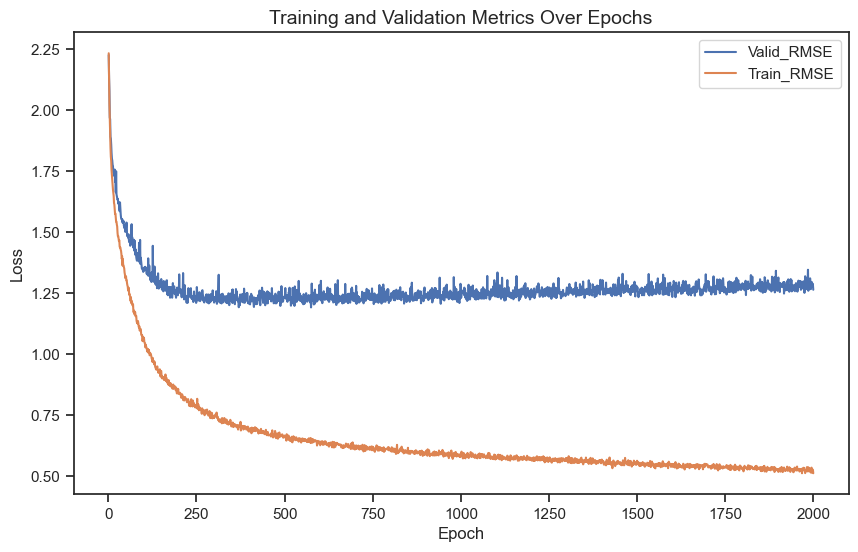

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [20]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.515938,0.514656,0.508607,0.508607,0.775433,0.880590,0.356924,NaN,1.294266,0.796548,0.796548,0.450000,0.685109,0.562877,0.454951,0.775437,1.292690
1996,1997,0.531152,0.524407,0.509303,0.509303,0.771178,0.878174,0.356428,NaN,1.275135,0.775339,0.775339,0.458130,0.689168,0.517742,0.458308,0.771190,1.273521
1997,1998,0.523882,0.524318,0.510871,0.510871,0.771217,0.878190,0.357281,NaN,1.289032,0.784035,0.784035,0.452225,0.685777,0.529418,0.452516,0.771217,1.287316
1998,1999,0.532872,0.526476,0.507461,0.507461,0.770275,0.877655,0.351162,NaN,1.283133,0.783863,0.783863,0.454731,0.686196,0.526254,0.455784,0.770278,1.281515
1999,2000,0.510731,0.511857,0.503622,0.503622,0.776654,0.881283,0.348260,NaN,1.263499,0.768750,0.768750,0.463075,0.690818,0.520474,0.463391,0.776655,1.261750


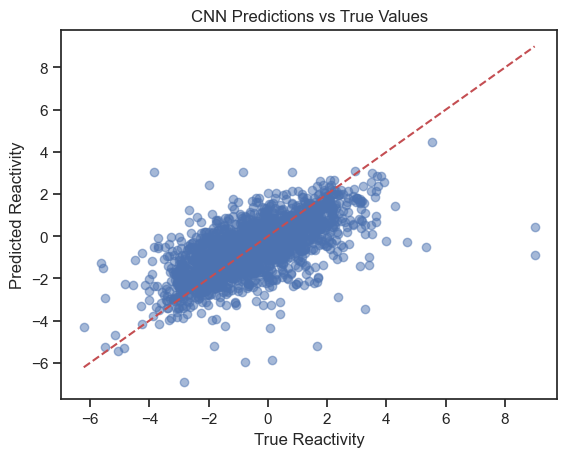

In [21]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("CNN Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()


In [ ]:
# 載入模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = r'.\pinchi_code\original dataset\trained_model\random_split'

# 需要知道訓練時的特徵維度
mol_input_dim = data.loc[0,'metabolite_features'].shape[0]  # 請替換成你的實際維度
protein_input_dim = data.loc[0,"protein_features"].shape[0]  # 請替換成你的實際維度

# 初始化模型並載入權重
model = CNNRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model.load_state_dict(torch.load(r"D:\backup\user\Documents\16_learning_project\large_file\04_software_tool\03_python\workspace\Huang_lab\pinchi_code\original dataset\trained_model\random_split\CNN model.pt", map_location=device))
model = model.to(device)
model.eval()  # 設定為評估模式

# 進行預測
def predict(model, mol_features, protein_features):
    """
    mol_features: numpy array or tensor, shape (batch_size, mol_input_dim)
    protein_features: numpy array or tensor, shape (batch_size, protein_input_dim)
    """
    with torch.no_grad():
        if isinstance(mol_features, np.ndarray):
            mol_features = torch.tensor(mol_features, dtype=torch.float32)
        if isinstance(protein_features, np.ndarray):
            protein_features = torch.tensor(protein_features, dtype=torch.float32)
        
        mol_features = mol_features.to(device)
        protein_features = protein_features.to(device)
        
        predictions = model(mol_features, protein_features)
        return predictions.cpu().numpy()

# 使用範例
mol_features = np.stack(data["metabolite_features"])
protein_features = np.stack(data["protein_features"])
predictions = predict(model, mol_features, protein_features)
print(f"Predicted Kd: {predictions}")


Predicted Kd: [-1.2273152  -0.73544484 -1.2427032  ... -0.92575186 -1.8436865
 -0.63367254]


In [25]:
import os
if os.path.exists('data_with_pred.joblib'):
    data_with_pred = joblib.load('data_with_pred.joblib')
else:
    data_with_pred = data.copy()

data_with_pred["CNN_pred"] = predictions
joblib.dump(data_with_pred, 'data_with_pred.joblib')
data_with_pred

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features,label,CAT_pred,CNN_pred
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126...",-1.303196,-0.664597,-1.227315
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10...",-0.832509,-0.298970,-0.735445
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096...",-1.278754,-0.836997,-1.242703
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0....",2.124939,1.427049,0.659172
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0....",1.408935,0.783579,1.170299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-2.980003,-1.987372,-2.852437
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.656514,-1.883750
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.541640,-0.925752
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737...",-0.826075,-0.926702,-1.843686
